# **Import Required Libraries**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import pickle
from scipy.stats import normaltest
from sklearn.model_selection import GridSearchCV


# **Load the Housing Dataset**

In [5]:
file_path = '/content/House Price Prediction Dataset.csv'
data = pd.read_csv(file_path)

# **Display dataset info**

In [7]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedrooms   2000 non-null   int64 
 3   Bathrooms  2000 non-null   int64 
 4   Floors     2000 non-null   int64 
 5   YearBuilt  2000 non-null   int64 
 6   Location   2000 non-null   object
 7   Condition  2000 non-null   object
 8   Garage     2000 non-null   object
 9   Price      2000 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 156.4+ KB
None


In [8]:
print(data.head())


   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970  Downtown  Excellent   
1   2  4272         5          4       3       1958  Downtown  Excellent   
2   3  3592         2          2       3       1938  Downtown       Good   
3   4   966         4          2       2       1902  Suburban       Fair   
4   5  4926         1          4       2       1975  Downtown       Fair   

  Garage   Price  
0     No  149919  
1     No  424998  
2     No  266746  
3    Yes  244020  
4    Yes  636056  


In [9]:
print(data.describe())

                Id         Area     Bedrooms   Bathrooms       Floors  \
count  2000.000000  2000.000000  2000.000000  2000.00000  2000.000000   
mean   1000.500000  2786.209500     3.003500     2.55250     1.993500   
std     577.494589  1295.146799     1.424606     1.10899     0.809188   
min       1.000000   501.000000     1.000000     1.00000     1.000000   
25%     500.750000  1653.000000     2.000000     2.00000     1.000000   
50%    1000.500000  2833.000000     3.000000     3.00000     2.000000   
75%    1500.250000  3887.500000     4.000000     4.00000     3.000000   
max    2000.000000  4999.000000     5.000000     4.00000     3.000000   

         YearBuilt          Price  
count  2000.000000    2000.000000  
mean   1961.446000  537676.855000  
std      35.926695  276428.845719  
min    1900.000000   50005.000000  
25%    1930.000000  300098.000000  
50%    1961.000000  539254.000000  
75%    1993.000000  780086.000000  
max    2023.000000  999656.000000  


# **Identify Features and Target**

In [12]:
target_column = 'Price'
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset. Please adjust the code.")

# Drop the identifier column
if 'Id' in data.columns:
    data = data.drop('Id', axis=1)

# Split into features (X) and target (y)
X = data.drop(target_column, axis=1)
y = data[target_column]

# Automatically detect categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify binary categorical features
binary_features = [
    col for col in categorical_features if data[col].nunique() == 2
]

print("\nCategorical Features:", categorical_features)
print("Numerical Features:", numerical_features)
print("Binary Categorical Features:", binary_features)



Categorical Features: ['Location', 'Condition', 'Garage']
Numerical Features: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
Binary Categorical Features: ['Garage']


# **Data Analysis**


In [13]:
#Check for missing values
print("\nMissing Values in Dataset:")
print(data.isnull().sum())




Missing Values in Dataset:
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64


# **Data Visualization**

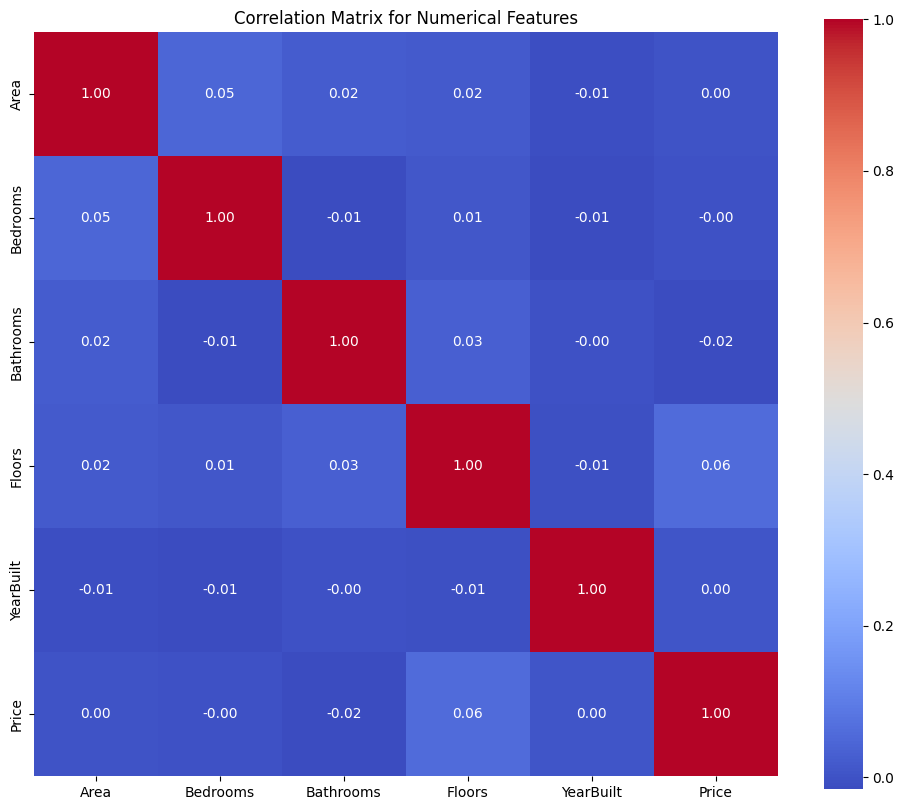

In [15]:
# Compute the correlation matrix only for numerical features
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Matrix for Numerical Features")
plt.show()


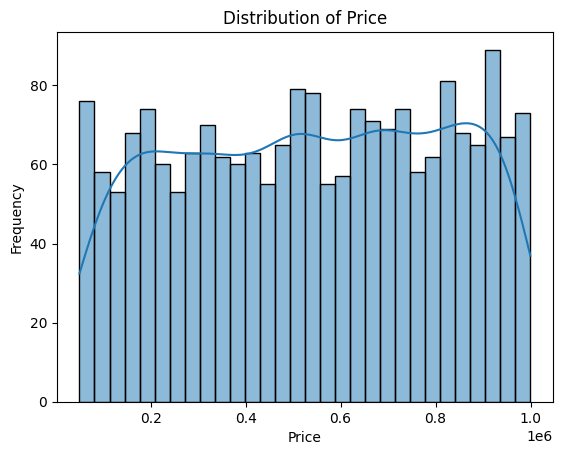

In [16]:
#Distribution of the target variable
sns.histplot(data[target_column], kde=True, bins=30)
plt.title(f"Distribution of {target_column}")
plt.xlabel(target_column)
plt.ylabel("Frequency")
plt.show()

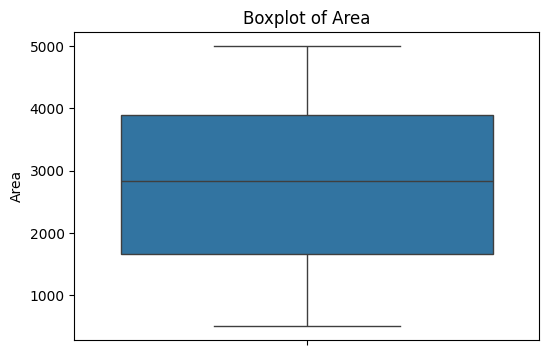

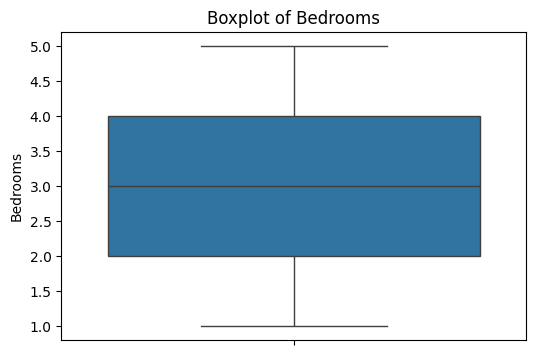

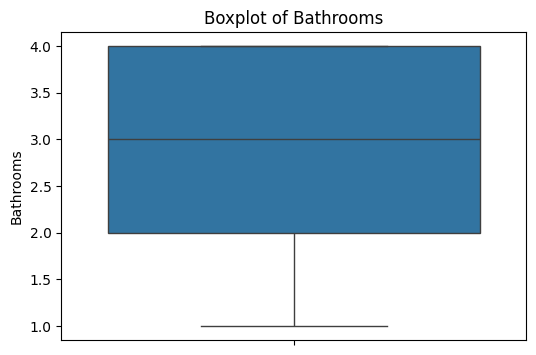

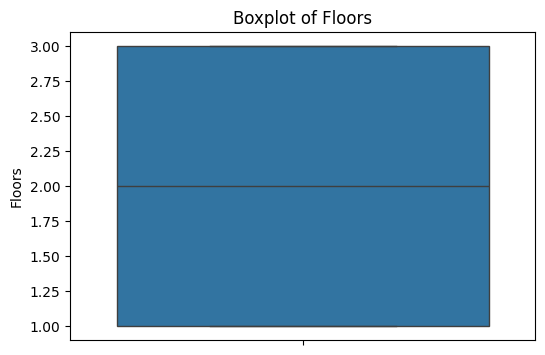

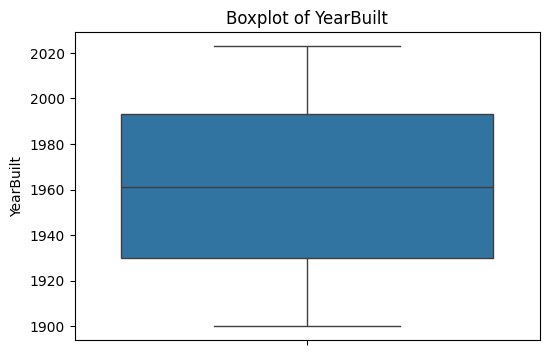

In [17]:
#Boxplots for outliers in numerical features
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()


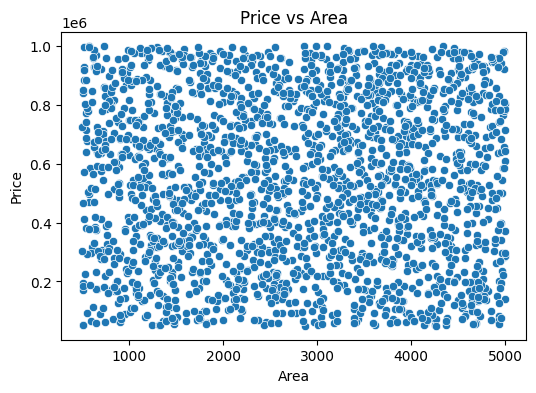

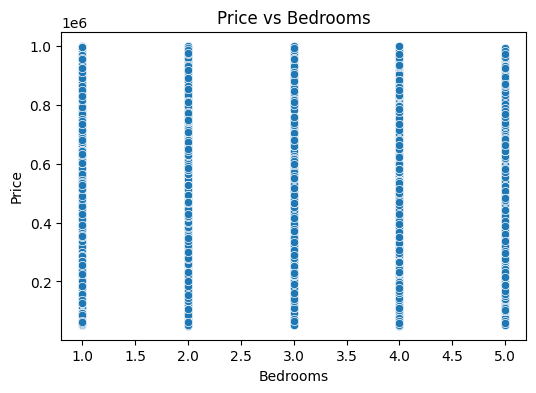

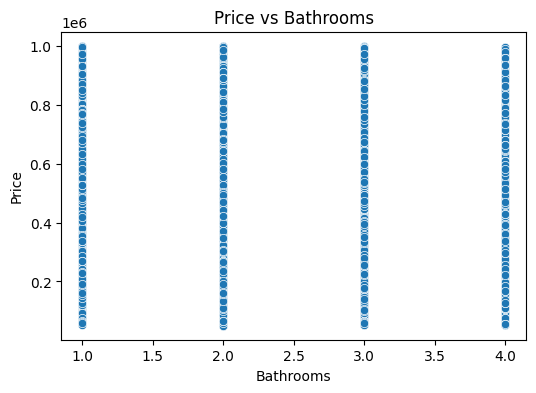

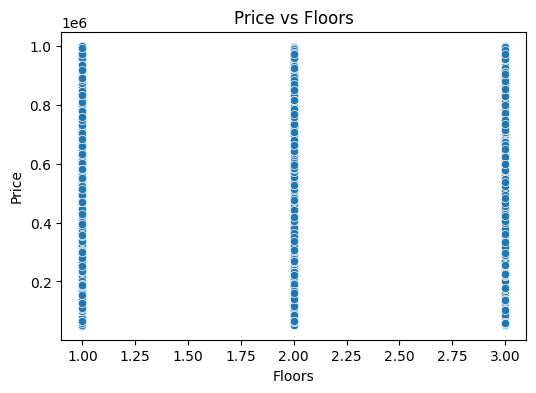

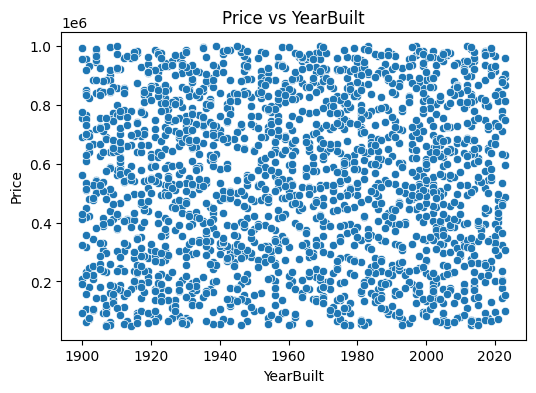

In [18]:
#Scatterplots for key numerical features vs target
for feature in numerical_features:
    if feature != target_column:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=data[feature], y=data[target_column])
        plt.title(f"{target_column} vs {feature}")
        plt.xlabel(feature)
        plt.ylabel(target_column)
        plt.show()

# **Preprocessing the Data**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# **Build Pipelines for All Models**

In [22]:
# Define models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=100, epsilon=0.1),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# Create pipelines for each model
pipelines = {
    name: Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ]) for name, model in models.items()
}


# **Train Models and Make Predictions**

In [23]:
predictions = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions[name] = pipeline.predict(X_test)

# **Evaluate All Models**

In [27]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define function to evaluate models
def evaluate_model(y_test, y_pred, model_name, X_test, preprocessor):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Preprocess X_test to ensure it's in the correct format (numeric)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Calculate p-value for regression significance using preprocessed X_test
    X_test_with_const = sm.add_constant(X_test_preprocessed)  # Add constant for intercept
    ols_model = sm.OLS(y_test, X_test_with_const).fit()  # Fit the OLS model
    p_value = ols_model.pvalues.min()  # Minimum p-value of predictors

    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Minimum p-value: {p_value:.4f}")
    print("-" * 30)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2, "p-value": p_value}

# Store evaluation results
evaluation_results = {}


for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    evaluation_results[name] = evaluate_model(y_test, y_pred, name, X_test, preprocessor)

# Display all evaluation results
print("\nEvaluation Results for All Models:")
for model_name, metrics in evaluation_results.items():
    print(f"{model_name}: MSE={metrics['MSE']:.2f}, MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R²']:.2f}, p-value={metrics['p-value']:.4f}")


Linear Regression Performance:
Mean Squared Error (MSE): 78321466146.03
Root Mean Squared Error (RMSE): 279859.73
Mean Absolute Error (MAE): 243241.98
R² Score: -0.01
Minimum p-value: 0.0000
------------------------------
Random Forest Performance:
Mean Squared Error (MSE): 85456610626.36
Root Mean Squared Error (RMSE): 292329.63
Mean Absolute Error (MAE): 252671.95
R² Score: -0.10
Minimum p-value: 0.0000
------------------------------
Gradient Boosting Performance:
Mean Squared Error (MSE): 80559984532.86
Root Mean Squared Error (RMSE): 283830.91
Mean Absolute Error (MAE): 245284.36
R² Score: -0.04
Minimum p-value: 0.0000
------------------------------
Support Vector Regressor Performance:
Mean Squared Error (MSE): 77903615835.29
Root Mean Squared Error (RMSE): 279112.19
Mean Absolute Error (MAE): 242683.11
R² Score: -0.00
Minimum p-value: 0.0000
------------------------------
K-Nearest Neighbors Performance:
Mean Squared Error (MSE): 101125945850.39
Root Mean Squared Error (RMSE): 31

# **Set Thresholds and Determine the Best Model**

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import numpy as np

# Define thresholds
r2_threshold = 0.75  # Minimum acceptable R² value
p_value_threshold = 0.05  # Maximum acceptable p-value

# Filter models meeting thresholds
valid_models = {
    name: metrics
    for name, metrics in evaluation_results.items()
    if metrics["R²"] >= r2_threshold and metrics["p-value"] <= p_value_threshold
}

# Function to re-train models with hyperparameter tuning
def retrain_model(model_name, pipeline):
    print(f"\nRe-training {model_name} with hyperparameter tuning...")
    param_grids = {
        "Linear Regression": {},  # No hyperparameters for linear regression
        "Random Forest": {
            "regressor__n_estimators": [100, 200, 300],
            "regressor__max_depth": [10, 20, 30],
        },
        "Gradient Boosting": {
            "regressor__n_estimators": [100, 200, 300],
            "regressor__learning_rate": [0.05, 0.1, 0.2],
            "regressor__max_depth": [3, 5, 7],
        },
        "Support Vector Regression": {
            "regressor__C": [0.1, 1, 10],
            "regressor__epsilon": [0.01, 0.1, 1],
        },
        "XGBoost": {
            "regressor__n_estimators": [100, 200, 300],
            "regressor__learning_rate": [0.05, 0.1, 0.2],
            "regressor__max_depth": [3, 5, 7],
        },
    }

    param_grid = param_grids.get(model_name, {})
    if not param_grid:
        print(f"No hyperparameter tuning available for {model_name}.")
        return pipeline

    grid_search = GridSearchCV(
        pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Check if valid models exist
if valid_models:
    # Select the model with the highest R²
    best_model_name = max(valid_models, key=lambda x: valid_models[x]["R²"])
    best_model_pipeline = pipelines[best_model_name]
    print(f"\nBest Model: {best_model_name}")
    print(f"R² Score: {valid_models[best_model_name]['R²']:.2f}")
    print(f"Minimum p-value: {valid_models[best_model_name]['p-value']:.4f}")
else:
    print("\nNo models met the specified thresholds. Re-training models...")
    # Re-train all models
    for model_name, pipeline in pipelines.items():
        pipelines[model_name] = retrain_model(model_name, pipeline)

    # Re-evaluate models after re-training
    evaluation_results = {}
    for name, pipeline in pipelines.items():
        y_pred = pipeline.predict(X_test)
        evaluation_results[name] = evaluate_model(y_test, y_pred, name, X_test, preprocessor)

    # Select the best model from re-trained results
    best_model_name = max(evaluation_results, key=lambda x: evaluation_results[x]["R²"])
    best_model_pipeline = pipelines[best_model_name]
    print(f"\nBest Model After Re-training: {best_model_name}")
    print(f"R² Score: {evaluation_results[best_model_name]['R²']:.2f}")
    print(f"Minimum p-value: {evaluation_results[best_model_name]['p-value']:.4f}")



No models met the specified thresholds. Re-training models...

Re-training Linear Regression with hyperparameter tuning...
No hyperparameter tuning available for Linear Regression.

Re-training Random Forest with hyperparameter tuning...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for Random Forest: {'regressor__max_depth': 10, 'regressor__n_estimators': 300}

Re-training Gradient Boosting with hyperparameter tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for Gradient Boosting: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}

Re-training Support Vector Regressor with hyperparameter tuning...
No hyperparameter tuning available for Support Vector Regressor.

Re-training K-Nearest Neighbors with hyperparameter tuning...
No hyperparameter tuning available for K-Nearest Neighbors.
Linear Regression Performance:
Mean Squared Error (MSE): 78321466146.03
Root Mean Squared Erro

# **Visualize Results for Best Model Example**

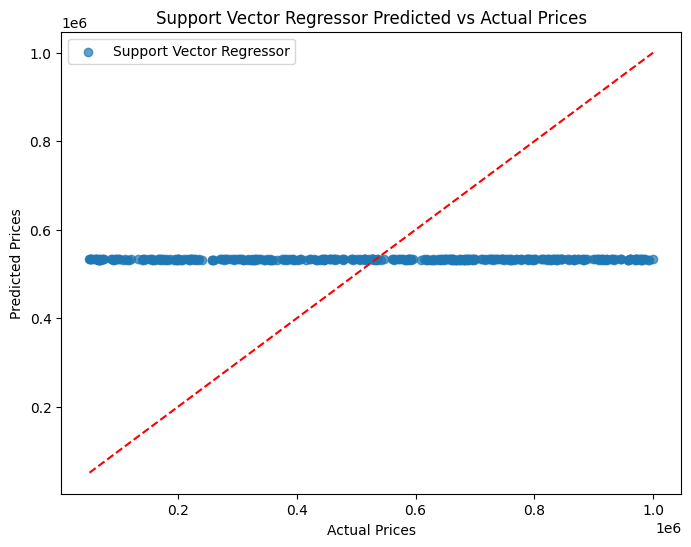

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions[best_model_name], alpha=0.7, label=best_model_name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title(f"{best_model_name} Predicted vs Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

# **Save the Best Model & Predict**

In [32]:
with open('house_price_model.pkl', 'wb') as f:
    pickle.dump(pipelines[best_model_name], f)

# Load the Best Model
with open('house_price_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Test the Loaded Model
sample_data = X_test[:1]  # Replace with custom input for predictions
predicted_price = loaded_model.predict(sample_data)
print("Loaded Model Test Prediction:", predicted_price)

Loaded Model Test Prediction: [533051.62151126]
